# Projeto para o Curso de Data Science ministrado pela Semantix Academy

## O notebook está dividido em "partes" que correspondem a cada etapa de um projeto "end-to-end" de data science.

### Introdução:

O objetivo da primeira parte desse notebook é criar o ambiente usado no projeto e a divisão de pastas para as análises posteriores, além de facilitar a obtenção do dataset de um modo automático e o processando dos dados de modo que seja extraido significado das variáveis sem que seja necessário a consulta ao dicionário de dados para o entendimento dos códigos.

A modelagem aplicada tem por objetivo facilitar o entendimendo do dataset de modo visual, para "humanos", por isso, variáveis como os códigos numéricos das respostas do questionário sócio-econômico por exemplo, foram convertidas para seus valores categóricos, mesmo que isso signifique um aumento do tamanho original dos dados, caso seja necessário a utilização de variáveis discretas ou contínuas em vez de categóricas, como por exemplo, na aplicação de algum algoritmo de machine learning, isso pode ser feito com a aplicação de alguma técnica de label encoding ou one hot encoding.

Na parte 2 será feita uma análise exploratória para melhor entendimento dos dados e extração de insights nos mesmos.


# Parte 1 - Engenharia de Dados

## Importando as dependências

In [1]:
# OBS: Como o tamanho do dataset é considerável (~3GB) e estamos usando o 
# ambiente em nuvem do google colab, foi adotado o uso do Spark para 
# exploração inicial dos dados.

# instalar as dependências - usar spark no google colab
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

# Seta as variáveis usadas pelo spark no ambiente do google colab
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql import functions as F

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Análise de dados do Enem 2019") \
    .getOrCreate()


In [2]:
spark

In [3]:
# Demais bibliotecas 
import os
import requests
from zipfile import ZipFile



## Criação dos diretórios do projeto e obtenção dos dados para análise.

In [4]:
# Cria a estrutura das pastas usadas no projeto:
# OBS: caso esteja rodando localmente, é sugerido que todos os scripts sejam 
# rodados dentro da mesma pasta para uma melhor organização.

# Cria no diretório atual a seguinte estrutura de pastas:
# ./DADOS
#     |___RAW           - Arquivos sem transformações 
#     |___REFINED       - Pasta com os arquivos transformados e manipulados para facilitar as visulaizações  

os.makedirs('./DADOS/RAW', exist_ok=True)
os.makedirs('./DADOS/REFINED',exist_ok=True)

O acesso ao conjunto de dados pode ser feito de várias formas diferentes. A seguir será mostrada alguns exemplos de acesso aos dados.


### Acesso via código e a biblioteca Requests

In [5]:
# # esta célula faz o download e a extração automática do arquivo zip através 
# # da biblioteca requests e salva dentro da pasta DADOS/RAW


# url = 'https://download.inep.gov.br/microdados/microdados_enem_2019.zip'
# local_file = './DADOS/RAW/dados_enem.zip'

# # faz o download do arquivo do site do Inep
# with requests.get(url, stream=True) as response:
#     response.raise_for_status()
#     with open(local_file, 'wb') as file: 
#         for chunk in response.iter_content():
#             file.write(chunk)

# # Extrai os dados do arquivo zip no diretório RAW
# with ZipFile(local_file, 'r') as file:
#     file.extractall('./DADOS/RAW')

### Acesso via Google Drive

Como o Google Colab é um ambiente em nuvem que perde os dados carregados em memória quando é encerrada a sua sessão, e para evitar o trabalho de fazer o upload/download todas as vezes que ele for reiniciado, será usado o método a seguir para conexão com os dados: 
- Montar um drive virtual com conexão com o Google Drive
-  Caminho do arquivo zip com os dados dentro da raiz do Google Drive: *Drive/Colab Notebooks/analise_enem/dados_enem.zip*

In [7]:
# Acesso via Google Colab 

from google.colab import drive
drive.mount('/content/drive')

local_file = '/content/drive/MyDrive/Colab Notebooks/analise_enem/dados_enem.zip'

# Extrai os dados do arquivo zip no diretório RAW
with ZipFile(local_file, 'r') as file:
    file.extractall('/content/DADOS/RAW')

Mounted at /content/drive


### Download Manual

É possivel fazer o download manualmente do site do inep 

**https://download.inep.gov.br/microdados/**

OBS: para o notebook atual está sendo considerado os dados do arquivo *microdados_enem_2019.zip* 

Depois de feito o download e extração dos arquivos, eles devem ser mantidos dentro da pasta DADOS/RAW para prosseguir com o notebook.

## Conhecendo os dados

In [8]:
itens = spark.read.csv('/content/DADOS/RAW/DADOS/ITENS_PROVA_2019.csv', header=True, sep=';', inferSchema=True)

In [9]:
itens.printSchema()

root
 |-- CO_POSICAO: integer (nullable = true)
 |-- SG_AREA: string (nullable = true)
 |-- CO_ITEM: integer (nullable = true)
 |-- TX_GABARITO: string (nullable = true)
 |-- CO_HABILIDADE: integer (nullable = true)
 |-- TX_COR: string (nullable = true)
 |-- CO_PROVA: integer (nullable = true)
 |-- TP_LINGUA: integer (nullable = true)
 |-- IN_ITEM_ADAPTADO: integer (nullable = true)



In [ ]:
itens.toPandas().head()

,CO_POSICAO,SG_AREA,CO_ITEM,TX_GABARITO,CO_HABILIDADE,TX_COR,CO_PROVA,TP_LINGUA,IN_ITEM_ADAPTADO
0,1,LC,55166,B,7,Azul,511,0.0,0
1,2,LC,54110,D,7,Azul,511,0.0,0
2,3,LC,23564,A,6,Azul,511,0.0,0
3,4,LC,31954,B,8,Azul,511,0.0,0
4,5,LC,118180,E,5,Azul,511,0.0,0


In [ ]:
itens.describe().show()

+-------+-----------------+-------+------------------+-----------+------------------+-------+-----------------+------------------+-------------------+
|summary|       CO_POSICAO|SG_AREA|           CO_ITEM|TX_GABARITO|     CO_HABILIDADE| TX_COR|         CO_PROVA|         TP_LINGUA|   IN_ITEM_ADAPTADO|
+-------+-----------------+-------+------------------+-----------+------------------+-------+-----------------+------------------+-------------------+
|  count|             1945|   1945|              1945|       1945|              1945|   1945|             1945|               110|               1945|
|   mean|85.94344473007712|   null| 76097.07197943445|       null|14.981491002570694|   null|530.6838046272494|               0.5|0.09511568123393316|
| stddev|53.11134249000579|   null|33731.599590580685|       null| 8.628218779006563|   null|19.75011772436883|0.5022883414749456| 0.2934501021196167|
|    min|                1|     CH|              6944|          A|                 1|Amarela| 

In [ ]:
itens.count()

1945

In [10]:
dados = spark.read.csv('/content/DADOS/RAW/DADOS/MICRODADOS_ENEM_2019.csv', header=True, sep=';', inferSchema=True)

In [11]:
dados.printSchema()

root
 |-- NU_INSCRICAO: long (nullable = true)
 |-- NU_ANO: integer (nullable = true)
 |-- CO_MUNICIPIO_RESIDENCIA: integer (nullable = true)
 |-- NO_MUNICIPIO_RESIDENCIA: string (nullable = true)
 |-- CO_UF_RESIDENCIA: integer (nullable = true)
 |-- SG_UF_RESIDENCIA: string (nullable = true)
 |-- NU_IDADE: integer (nullable = true)
 |-- TP_SEXO: string (nullable = true)
 |-- TP_ESTADO_CIVIL: integer (nullable = true)
 |-- TP_COR_RACA: integer (nullable = true)
 |-- TP_NACIONALIDADE: integer (nullable = true)
 |-- CO_MUNICIPIO_NASCIMENTO: integer (nullable = true)
 |-- NO_MUNICIPIO_NASCIMENTO: string (nullable = true)
 |-- CO_UF_NASCIMENTO: integer (nullable = true)
 |-- SG_UF_NASCIMENTO: string (nullable = true)
 |-- TP_ST_CONCLUSAO: integer (nullable = true)
 |-- TP_ANO_CONCLUIU: integer (nullable = true)
 |-- TP_ESCOLA: integer (nullable = true)
 |-- TP_ENSINO: integer (nullable = true)
 |-- IN_TREINEIRO: integer (nullable = true)
 |-- CO_ESCOLA: integer (nullable = true)
 |-- CO_MU

In [12]:
type(dados)

pyspark.sql.dataframe.DataFrame

In [ ]:
dados.describe().show()

+-------+--------------------+-------+-----------------------+-----------------------+------------------+----------------+-----------------+-------+------------------+------------------+------------------+-----------------------+-----------------------+------------------+----------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+----------------+------------------+---------+----------------------+-------------------+------------------+--------------------+--------------------+--------------------+-----------------------+--------------------+---------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------------------+--------------------+--------------------+--------------------+--------------------+--------------

In [ ]:
dados.count()

5095270

Depois de uma rápida verificação nos dados ficou decidido dividir as informações por grupos menores para facilitar o entendimento e a manipulação dos dados.


Foi usando como referência o dicionário de dados que está junto das informações do arquivo zip (/content/DADOS/RAW/DICION╡RIO/Dicionário_Microdados_Enem_2019.xlsx)
e divisão nos seguintes grupos:

- Informações dos participantes do Enem
- Dados das escolas participantes
- Pedidos de realização de prova com atendimento específico ou especializado
- Solicitações de recursos especiais para a realização da prova
- Dados sobre a prova
- Questionário Sócio-econômico.

## Divisão dos dados




### Informações dos participantes do Enem

In [13]:
# verifica os anos de realização do enem no dataset, para definir se será mantida 
dados.select('NU_ANO').distinct().show()

+------+
|NU_ANO|
+------+
|  2019|
+------+



In [14]:
# dados do participante 
participantes = dados.select(
      F.col('NU_INSCRICAO').alias('INSCRICAO'),F.col('NO_MUNICIPIO_RESIDENCIA').alias('MUNICIPIO_RESIDENCIA')
      ,F.col('SG_UF_RESIDENCIA').alias('UF_RESIDENCIA'),F.col('NU_IDADE').alias('IDADE'), \
      F.col('TP_SEXO').alias('SEXO'),F.col('TP_ESTADO_CIVIL').alias('ESTADO_CIVIL'), \
      F.col('TP_COR_RACA').alias('COR'),F.col('TP_NACIONALIDADE').alias('NACIONALIDADE'), \
      F.col('NO_MUNICIPIO_NASCIMENTO').alias('MUNICIPIO_NASCIMENTO'),F.col('SG_UF_NASCIMENTO').alias('UF_NASCIMENTO'), \
      F.col('TP_ST_CONCLUSAO').alias('STATUS_ENSINO_MEDIO'), \
      F.col('TP_ANO_CONCLUIU').alias('ANO_CONCLUSAO'),F.col('TP_ESCOLA').alias('TIPO_ESCOLA'), \
      F.col('TP_ENSINO').alias('TIPO_MODALIDADE'),F.col('IN_TREINEIRO').alias('TREINEIRO')) \
      .withColumn("SEXO", 
                  F.when(F.col('SEXO') == 'M', 'MASCULINO') \
                  .when(F.col('SEXO') == 'F', 'FEMININO') \
                  .otherwise(F.col('SEXO'))) \
      .withColumn("ESTADO_CIVIL", \
                  F.when(F.col('ESTADO_CIVIL') == 0, 'Não Informado') \
                  .when(F.col('ESTADO_CIVIL') == 1, 'Solteiro(a)') \
                  .when(F.col('ESTADO_CIVIL') == 2, 'Casado(a)/Mora com companheiro(a)') \
                  .when(F.col('ESTADO_CIVIL') == 3, 'Divorciado(a)/Desquitado(a)/Separado(a)') \
                  .when(F.col('ESTADO_CIVIL') == 4, 'Viúvo(a)') \
                  .otherwise(F.col('ESTADO_CIVIL'))) \
      .withColumn("COR", \
                  F.when(F.col('COR') == 0, 'Não declarado') \
                  .when(F.col('COR') == 1, 'Branca') \
                  .when(F.col('COR') == 2, 'Afrodescendente') \
                  .when(F.col('COR') == 3, 'Parda') \
                  .when(F.col('COR') == 4, 'Amarela') \
                  .when(F.col('COR') == 5, 'Indígena') \
                  .otherwise(F.col('COR'))) \
      .withColumn("NACIONALIDADE", \
                  F.when(F.col('NACIONALIDADE') == 0, 'Não informado') \
                  .when(F.col('NACIONALIDADE') == 1, 'Brasileiro(a)') \
                  .when(F.col('NACIONALIDADE') == 2, 'Brasileiro(a) Naturalizado') \
                  .when(F.col('NACIONALIDADE') == 3, 'Estrangeiro(a)') \
                  .when(F.col('NACIONALIDADE') == 4, 'Brasileiro(a) Nato(a), nascido(a) no exterior') \
                  .otherwise(F.col('NACIONALIDADE'))) \
      .withColumn("STATUS_ENSINO_MEDIO", \
                  F.when(F.col('STATUS_ENSINO_MEDIO') == 1, 'Já concluí o Ensino Médio') \
                  .when(F.col('STATUS_ENSINO_MEDIO') == 2, 'Estou cursando e concluirei o Ensino Médio em 2019') \
                  .when(F.col('STATUS_ENSINO_MEDIO') == 3, 'Estou cursando e concluirei o Ensino Médio após 2019') \
                  .when(F.col('STATUS_ENSINO_MEDIO') == 4, 'Não concluí e não estou cursando o Ensino Médio') \
                  .otherwise(F.col('STATUS_ENSINO_MEDIO'))) \
      .withColumn("ANO_CONCLUSAO", \
                  F.when(F.col('ANO_CONCLUSAO') == 0, 'Não informado') \
                  .when(F.col('ANO_CONCLUSAO') == 1, '2018') \
                  .when(F.col('ANO_CONCLUSAO') == 2, '2017') \
                  .when(F.col('ANO_CONCLUSAO') == 3, '2016') \
                  .when(F.col('ANO_CONCLUSAO') == 4, '2015') \
                  .when(F.col('ANO_CONCLUSAO') == 5, '2014') \
                  .when(F.col('ANO_CONCLUSAO') == 6, '2013') \
                  .when(F.col('ANO_CONCLUSAO') == 7, '2012') \
                  .when(F.col('ANO_CONCLUSAO') == 8, '2011') \
                  .when(F.col('ANO_CONCLUSAO') == 9, '2010') \
                  .when(F.col('ANO_CONCLUSAO') == 10, '2009') \
                  .when(F.col('ANO_CONCLUSAO') == 11, '2008') \
                  .when(F.col('ANO_CONCLUSAO') == 12, '2007') \
                  .when(F.col('ANO_CONCLUSAO') == 13, 'Antes de 2007') \
                  .otherwise(F.col('ANO_CONCLUSAO'))) \
      .withColumn("TIPO_ESCOLA", \
                  F.when(F.col('TIPO_ESCOLA') == 1, 'Não Respondeu') \
                  .when(F.col('TIPO_ESCOLA') == 2, 'Pública') \
                  .when(F.col('TIPO_ESCOLA') == 3, 'Privada') \
                  .when(F.col('TIPO_ESCOLA') == 4, 'Exterior') \
                  .otherwise(F.col('TIPO_ESCOLA'))) \
      .withColumn("TIPO_MODALIDADE", \
                  F.when(F.col('TIPO_MODALIDADE') == 1, 'Ensino Regular') \
                  .when(F.col('TIPO_MODALIDADE') == 2, 'Educação Especial - Modalidade Substitutiva') \
                  .when(F.col('TIPO_MODALIDADE') == 3, 'Educação de Jovens e Adultos') \
                  .otherwise(F.col('TIPO_MODALIDADE'))) \
      .withColumn("TREINEIRO", 
                  F.when(F.col('TREINEIRO') == 1, 'SIM') \
                  .when(F.col('TREINEIRO') == 0, 'NÃO') \
                  .otherwise(F.col('TREINEIRO')))

In [41]:
participantes.show()

+------------+--------------------+-------------+-----+---------+--------------------+---------------+-------------+--------------------+-------------+--------------------+-------------+-------------+--------------------+---------+
|   INSCRICAO|MUNICIPIO_RESIDENCIA|UF_RESIDENCIA|IDADE|     SEXO|        ESTADO_CIVIL|            COR|NACIONALIDADE|MUNICIPIO_NASCIMENTO|UF_NASCIMENTO| STATUS_ENSINO_MEDIO|ANO_CONCLUSAO|  TIPO_ESCOLA|     TIPO_MODALIDADE|TREINEIRO|
+------------+--------------------+-------------+-----+---------+--------------------+---------------+-------------+--------------------+-------------+--------------------+-------------+-------------+--------------------+---------+
|190001595656|            Sorocaba|           SP|   36|MASCULINO|         Solteiro(a)|          Parda|Brasileiro(a)|             Itabuna|           BA|Já concluí o Ensi...|         2008|Não Respondeu|                null|      NÃO|
|190001421546|    Feira de Santana|           BA|   23|MASCULINO|       

In [15]:
participantes.repartition(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save('./DADOS/REFINED/PARTICIPANTES/')

### Dados da escola

In [16]:
escola = dados.select(
      F.col('CO_ESCOLA'),F.col('NO_MUNICIPIO_ESC').alias('MUNICIPIO'),
      F.col('SG_UF_ESC').alias('UF'),F.col('TP_DEPENDENCIA_ADM_ESC').alias('DEPENDENCIA_ADM'),
      F.col('TP_LOCALIZACAO_ESC').alias('LOCALIZACAO'),F.col('TP_SIT_FUNC_ESC').alias('SITUACAO_FUNCIONAMENTO')) \
      .withColumn("DEPENDENCIA_ADM", \
                  F.when(F.col('DEPENDENCIA_ADM') == 1, 'Federal') \
                  .when(F.col('DEPENDENCIA_ADM') == 2, 'Estadual') \
                  .when(F.col('DEPENDENCIA_ADM') == 3, 'Municipal') \
                  .when(F.col('DEPENDENCIA_ADM') == 4, 'Privada') \
                  .otherwise(F.col('DEPENDENCIA_ADM'))) \
      .withColumn("LOCALIZACAO", \
                  F.when(F.col('LOCALIZACAO') == 1, 'Urbana') \
                  .when(F.col('LOCALIZACAO') == 2, 'Rural') \
                  .otherwise(F.col('LOCALIZACAO'))) \
      .withColumn("SITUACAO_FUNCIONAMENTO", \
                  F.when(F.col('SITUACAO_FUNCIONAMENTO') == 1, 'Em atividade') \
                  .when(F.col('SITUACAO_FUNCIONAMENTO') == 2, 'Paralisada') \
                  .when(F.col('SITUACAO_FUNCIONAMENTO') == 3, 'Extinta') \
                  .otherwise(F.col('SITUACAO_FUNCIONAMENTO')))

In [40]:
escola.show()

+---------+----------+----+---------------+-----------+----------------------+
|CO_ESCOLA| MUNICIPIO|  UF|DEPENDENCIA_ADM|LOCALIZACAO|SITUACAO_FUNCIONAMENTO|
+---------+----------+----+---------------+-----------+----------------------+
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       null|                  null|
|     null|      null|null|           null|       nu

In [17]:
escola.repartition(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save('./DADOS/REFINED/ESCOLAS/')

### Pedidos de realização de prova com atendimento específico ou especializado

In [18]:
colunas = ['IN_BAIXA_VISAO','IN_CEGUEIRA','IN_SURDEZ','IN_DEFICIENCIA_AUDITIVA',
      'IN_SURDO_CEGUEIRA','IN_DEFICIENCIA_FISICA','IN_DEFICIENCIA_MENTAL',
      'IN_DEFICIT_ATENCAO','IN_DISLEXIA','IN_DISCALCULIA','IN_AUTISMO',
      'IN_VISAO_MONOCULAR','IN_OUTRA_DEF','IN_GESTANTE','IN_LACTANTE',
      'IN_IDOSO','IN_ESTUDA_CLASSE_HOSPITALAR']

atendimento_especifico = dados.select(colunas)

for i in colunas:
  atendimento_especifico = atendimento_especifico.withColumn(i, F.when(F.col(i) == 1, 'Sim') \
                                    .when(F.col(i) == 0, 'Não') \
                                    .otherwise(F.col(i)))


In [39]:
atendimento_especifico.show()

+--------------+-----------+---------+-----------------------+-----------------+---------------------+---------------------+------------------+-----------+--------------+----------+------------------+------------+-----------+-----------+--------+---------------------------+
|IN_BAIXA_VISAO|IN_CEGUEIRA|IN_SURDEZ|IN_DEFICIENCIA_AUDITIVA|IN_SURDO_CEGUEIRA|IN_DEFICIENCIA_FISICA|IN_DEFICIENCIA_MENTAL|IN_DEFICIT_ATENCAO|IN_DISLEXIA|IN_DISCALCULIA|IN_AUTISMO|IN_VISAO_MONOCULAR|IN_OUTRA_DEF|IN_GESTANTE|IN_LACTANTE|IN_IDOSO|IN_ESTUDA_CLASSE_HOSPITALAR|
+--------------+-----------+---------+-----------------------+-----------------+---------------------+---------------------+------------------+-----------+--------------+----------+------------------+------------+-----------+-----------+--------+---------------------------+
|           Não|        Não|      Não|                    Não|              Não|                  Não|                  Não|               Não|        Não|           Não|     

In [19]:
atendimento_especifico.repartition(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save('./DADOS/REFINED/ATENDIMENTO_ESPECIFICO/')

### Solicitações de recursos especiais para a realização da prova

In [20]:
colunas = ['IN_SEM_RECURSO','IN_BRAILLE','IN_AMPLIADA_24','IN_AMPLIADA_18',
           'IN_LEDOR','IN_ACESSO','IN_TRANSCRICAO','IN_LIBRAS','IN_TEMPO_ADICIONAL',
           'IN_LEITURA_LABIAL','IN_MESA_CADEIRA_RODAS','IN_MESA_CADEIRA_SEPARADA',
           'IN_APOIO_PERNA','IN_GUIA_INTERPRETE','IN_COMPUTADOR','IN_CADEIRA_ESPECIAL',
           'IN_CADEIRA_CANHOTO','IN_CADEIRA_ACOLCHOADA','IN_PROVA_DEITADO',
           'IN_MOBILIARIO_OBESO','IN_LAMINA_OVERLAY','IN_PROTETOR_AURICULAR',
           'IN_MEDIDOR_GLICOSE','IN_MAQUINA_BRAILE','IN_SOROBAN','IN_MARCA_PASSO',
           'IN_SONDA','IN_MEDICAMENTOS','IN_SALA_INDIVIDUAL','IN_SALA_ESPECIAL',
           'IN_SALA_ACOMPANHANTE','IN_MOBILIARIO_ESPECIFICO','IN_MATERIAL_ESPECIFICO',
           'IN_NOME_SOCIAL']

recursos_especiais = dados.select(colunas)

for i in colunas:
  recursos_especiais = recursos_especiais.withColumn(i, F.when(F.col(i) == 1, 'Sim') \
                                    .when(F.col(i) == 0, 'Não') \
                                    .otherwise(F.col(i)))

In [38]:
recursos_especiais.show()

+--------------+----------+--------------+--------------+--------+---------+--------------+---------+------------------+-----------------+---------------------+------------------------+--------------+------------------+-------------+-------------------+------------------+---------------------+----------------+-------------------+-----------------+---------------------+------------------+-----------------+----------+--------------+--------+---------------+------------------+----------------+--------------------+------------------------+----------------------+--------------+
|IN_SEM_RECURSO|IN_BRAILLE|IN_AMPLIADA_24|IN_AMPLIADA_18|IN_LEDOR|IN_ACESSO|IN_TRANSCRICAO|IN_LIBRAS|IN_TEMPO_ADICIONAL|IN_LEITURA_LABIAL|IN_MESA_CADEIRA_RODAS|IN_MESA_CADEIRA_SEPARADA|IN_APOIO_PERNA|IN_GUIA_INTERPRETE|IN_COMPUTADOR|IN_CADEIRA_ESPECIAL|IN_CADEIRA_CANHOTO|IN_CADEIRA_ACOLCHOADA|IN_PROVA_DEITADO|IN_MOBILIARIO_OBESO|IN_LAMINA_OVERLAY|IN_PROTETOR_AURICULAR|IN_MEDIDOR_GLICOSE|IN_MAQUINA_BRAILE|IN_SOROBAN|I

In [21]:
recursos_especiais.repartition(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save('./DADOS/REFINED/RECURSOS_ESPECIAIS/')

### Dados sobre a prova

In [22]:
provas = dados.select(F.col('NO_MUNICIPIO_PROVA').alias('MUNICIPIO'),
             F.col('SG_UF_PROVA').alias('UF'),
             F.col('TP_PRESENCA_CN').alias('PRESENCA_CIENCIAS_NATUREZA'),
             F.col('TP_PRESENCA_CH').alias('PRESENCA_CIENCIAS_HUMANAS'),
             F.col('TP_PRESENCA_LC').alias('PRESENCA_LINGUAGEM_CODIGOS'),
             F.col('TP_PRESENCA_MT').alias('PRESENCA_MATEMATICA'),
             F.col('CO_PROVA_CN').alias('TIPO_PROVA_CIENCIAS_NATUREZA'),
             F.col('CO_PROVA_CH').alias('TIPO_PROVA_CIENCIAS_HUMANAS'),
             F.col('CO_PROVA_LC').alias('TIPO_PROVA_LINGUAGEM_CODIGOS'),
             F.col('CO_PROVA_MT').alias('TIPO_PROVA_MATEMATICA'),
             F.col('NU_NOTA_CN').alias('NOTA_PROVA_MATEMATICA'),
             F.col('NU_NOTA_CH').alias('NOTA_CIENCIAS_HUMANAS'),
             F.col('NU_NOTA_LC').alias('NOTA_LINGUAGEM_CODIGOS'),
             F.col('NU_NOTA_MT').alias('NOTA_MATEMATICA'),
             F.col('TP_LINGUA').alias('LINGUA_ESTRANGEIRA'),
             F.col('TP_STATUS_REDACAO').alias('STATUS_REDACAO'),
             F.col('NU_NOTA_COMP1').alias('NOTA_COMPETENCIA_1'),
             F.col('NU_NOTA_COMP2').alias('NOTA_COMPETENCIA_2'),
             F.col('NU_NOTA_COMP3').alias('NOTA_COMPETENCIA_3'),
             F.col('NU_NOTA_COMP4').alias('NOTA_COMPETENCIA_4'),
             F.col('NU_NOTA_COMP5').alias('NOTA_COMPETENCIA_5'),
             F.col('NU_NOTA_REDACAO').alias('NOTA_REDACAO'))

In [23]:
for i in ['PRESENCA_CIENCIAS_NATUREZA','PRESENCA_CIENCIAS_HUMANAS','PRESENCA_LINGUAGEM_CODIGOS','PRESENCA_MATEMATICA']:
  provas = provas.withColumn(i, F.when(F.col(i) == 0, 'Faltou à prova') \
                             .when(F.col(i) == 1, 'Presente na prova') \
                             .when(F.col(i) == 2, 'Eliminado na prova') \
                             .otherwise(F.col(i)))

In [24]:
provas = provas.withColumn("TIPO_PROVA_CIENCIAS_NATUREZA", \
                  F.when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 503, 'Azul') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 504, 'Amarela') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 505, 'Cinza') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 506, 'Rosa') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 519, 'Laranja - Adaptada Ledor') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 523, 'Verde - Videoprova - Libras') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 543, 'Amarela (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 544, 'Cinza (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 545, 'Azul (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_NATUREZA') == 546, 'Rosa (Reaplicação)') \
                  .otherwise(F.col('TIPO_PROVA_CIENCIAS_NATUREZA'))) \
      .withColumn("TIPO_PROVA_CIENCIAS_HUMANAS", \
                  F.when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 507, 'Azul') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 508, 'Amarela') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 509, 'Branca') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 510, 'Rosa') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 520, 'Laranja - Adaptada Ledor') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 524, 'Verde - Videoprova - Libras') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 547, 'Azul (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 548, 'Amarelo (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 549, 'Branco (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 550, 'Rosa (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_CIENCIAS_HUMANAS') == 564, 'Laranja - Adaptada Ledor (Reaplicação)') \
                  .otherwise(F.col('TIPO_PROVA_CIENCIAS_HUMANAS'))) \
      .withColumn("TIPO_PROVA_LINGUAGEM_CODIGOS", \
                  F.when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 511, 'Azul') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 512, 'Amarela') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 513, 'Rosa') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 514, 'Branca') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 521, 'Laranja - Adaptada Ledor') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 525, 'Verde - Videoprova - Libras') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 551, 'Azul (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 552, 'Amarelo (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 553, 'Branca (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 554, 'Rosa (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS') == 565, 'Laranja - Adaptada Ledor (Reaplicação)') \
                  .otherwise(F.col('TIPO_PROVA_LINGUAGEM_CODIGOS'))) \
      .withColumn("TIPO_PROVA_MATEMATICA", \
                  F.when(F.col('TIPO_PROVA_MATEMATICA') == 515, 'Azul') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 516, 'Amarela') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 518, 'Cinza') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 517, 'Rosa') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 522, 'Laranja - Adaptada Ledor') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 526, 'Verde - Videoprova - Libras') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 555, 'Amarela (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 556, 'Cinza (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 557, 'Azul (Reaplicação)') \
                  .when(F.col('TIPO_PROVA_MATEMATICA') == 558, 'Rosa (Reaplicação)') \
                  .otherwise(F.col('TIPO_PROVA_MATEMATICA'))) \
      .withColumn("LINGUA_ESTRANGEIRA", \
                  F.when(F.col('LINGUA_ESTRANGEIRA') == 0, 'Inglês') \
                  .when(F.col('LINGUA_ESTRANGEIRA') == 1, 'Espanhol') \
                  .otherwise(F.col('LINGUA_ESTRANGEIRA'))) \
      .withColumn("STATUS_REDACAO", \
                  F.when(F.col('STATUS_REDACAO') == 1, 'Sem problemas') \
                  .when(F.col('STATUS_REDACAO') == 2, 'Anulada') \
                  .when(F.col('STATUS_REDACAO') == 3, 'Cópia Texto Motivador') \
                  .when(F.col('STATUS_REDACAO') == 4, 'Em branco') \
                  .when(F.col('STATUS_REDACAO') == 6, 'Fuga ao tema') \
                  .when(F.col('STATUS_REDACAO') == 7, 'Não atendimento ao tipo textual') \
                  .when(F.col('STATUS_REDACAO') == 8, 'Texto insuficiente') \
                  .when(F.col('STATUS_REDACAO') == 9, 'Parte desconectada') \
                  .otherwise(F.col('STATUS_REDACAO'))) 

In [37]:
provas.show()

+----------------+---+--------------------------+-------------------------+--------------------------+-------------------+----------------------------+---------------------------+----------------------------+---------------------+---------------------+---------------------+----------------------+---------------+------------------+--------------+------------------+------------------+------------------+------------------+------------------+------------+
|       MUNICIPIO| UF|PRESENCA_CIENCIAS_NATUREZA|PRESENCA_CIENCIAS_HUMANAS|PRESENCA_LINGUAGEM_CODIGOS|PRESENCA_MATEMATICA|TIPO_PROVA_CIENCIAS_NATUREZA|TIPO_PROVA_CIENCIAS_HUMANAS|TIPO_PROVA_LINGUAGEM_CODIGOS|TIPO_PROVA_MATEMATICA|NOTA_PROVA_MATEMATICA|NOTA_CIENCIAS_HUMANAS|NOTA_LINGUAGEM_CODIGOS|NOTA_MATEMATICA|LINGUA_ESTRANGEIRA|STATUS_REDACAO|NOTA_COMPETENCIA_1|NOTA_COMPETENCIA_2|NOTA_COMPETENCIA_3|NOTA_COMPETENCIA_4|NOTA_COMPETENCIA_5|NOTA_REDACAO|
+----------------+---+--------------------------+-------------------------+-------------

In [25]:
provas.repartition(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save('./DADOS/REFINED/PROVAS/')

### Dados Sócio-econômico

In [26]:
socioeconomico = dados.select(F.col('Q001').alias('ESCOLARIDADE_PAI_OU_RESPONSAVEL'),
                              F.col('Q002').alias('ESCOLARIDADE_MAE_OU_RESPONSAVEL'),
                              F.col('Q003').alias('GRUPO_OCUPACAO_PAI'),
                              F.col('Q004').alias('GRUPO_OCUPACAO_MAE'),
                              F.col('Q005').alias('QTD_MORADORES_RESIDENCIA'),
                              F.col('Q006').alias('RENDA_MENSAL_FAMILIAR'),
                              F.col('Q007').alias('POSSUI_SERVICO_EMPREGADO_DOMESTICO'),
                              F.col('Q008').alias('QTD_BANHEIROS_RESIDENCIA'),
                              F.col('Q009').alias('QTD_QUARTOS_RESIDENCIA'),
                              F.col('Q010').alias('TEM_CARRO'),
                              F.col('Q011').alias('TEM_MOTO'),
                              F.col('Q012').alias('TEM_GELADEIRA'),
                              F.col('Q013').alias('TEM_FREEZER_OU_SEGUNDA_PORTA_GELADEIRA'),
                              F.col('Q014').alias('TEM_MAQUINA_LAVAR'),
                              F.col('Q015').alias('TEM_MAQUINA_SECAR'),
                              F.col('Q016').alias('TEM_MICROONDAS'),
                              F.col('Q017').alias('TEM_MAQUINA_LAVAR_LOUCA'),
                              F.col('Q018').alias('TEM_ASPIRADOR_PO'),
                              F.col('Q019').alias('TEM_TELEVISAO'),
                              F.col('Q020').alias('TEM_DVD'),
                              F.col('Q021').alias('TEM_TV_ASSINATURA'),
                              F.col('Q022').alias('TEM_TELEFONE_CELULAR'),
                              F.col('Q023').alias('TEM_TELEFONE_FIXO'),
                              F.col('Q024').alias('TEM_COMPUTADOR'),
                              F.col('Q025').alias('TEM_ACESSO_INTERNET'))

In [27]:
socioeconomico = socioeconomico \
    .withColumn("ESCOLARIDADE_PAI_OU_RESPONSAVEL", \
               F.when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'A', 'Nunca estudou.') \
               .when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'B', 'Não completou a 4ª série/5º ano do Ensino Fundamental.') \
               .when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'C', 'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.') \
               .when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'D', 'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.') \
               .when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'E', 'Completou o Ensino Médio, mas não completou a Faculdade.') \
               .when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'F', 'Completou a Faculdade, mas não completou a Pós-graduação.') \
               .when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'G', 'Completou a Pós-graduação.') \
               .when(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL') == 'H', 'Não sei.') \
               .otherwise(F.col('ESCOLARIDADE_PAI_OU_RESPONSAVEL'))) \
    .withColumn("ESCOLARIDADE_MAE_OU_RESPONSAVEL", \
                F.when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'A', 'Nunca estudou.') \
                .when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'B', 'Não completou a 4ª série/5º ano do Ensino Fundamental.') \
                .when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'C', 'Completou a 4ª série/5º ano, mas não completou a 8ª série/9º ano do Ensino Fundamental.') \
                .when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'D', 'Completou a 8ª série/9º ano do Ensino Fundamental, mas não completou o Ensino Médio.') \
                .when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'E', 'Completou o Ensino Médio, mas não completou a Faculdade.') \
                .when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'F', 'Completou a Faculdade, mas não completou a Pós-graduação.') \
                .when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'G', 'Completou a Pós-graduação.') \
                .when(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL') == 'H', 'Não sei.') \
                .otherwise(F.col('ESCOLARIDADE_MAE_OU_RESPONSAVEL'))) \
    .withColumn("GRUPO_OCUPACAO_PAI", \
                F.when(F.col('GRUPO_OCUPACAO_PAI') == 'A', 'Grupo 1: Lavrador, agricultor sem empregados, bóia fria, criador de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultor, pescador, lenhador, seringueiro, extrativista.') \
                .when(F.col('GRUPO_OCUPACAO_PAI') == 'B', 'Grupo 2: Diarista, empregado doméstico, cuidador de idosos, babá, cozinheiro (em casas particulares), motorista particular, jardineiro, faxineiro de empresas e prédios, vigilante, porteiro, carteiro, office-boy, vendedor, caixa, atendente de loja, auxiliar administrativo, recepcionista, servente de pedreiro, repositor de mercadoria.') \
                .when(F.col('GRUPO_OCUPACAO_PAI') == 'C', 'Grupo 3: Padeiro, cozinheiro industrial ou em restaurantes, sapateiro, costureiro, joalheiro, torneiro mecânico, operador de máquinas, soldador, operário de fábrica, trabalhador da mineração, pedreiro, pintor, eletricista, encanador, motorista, caminhoneiro, taxista.') \
                .when(F.col('GRUPO_OCUPACAO_PAI') == 'D', 'Grupo 4: Professor (de ensino fundamental ou médio, idioma, música, artes etc.), técnico (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretor de imóveis, supervisor, gerente, mestre de obras, pastor, microempresário (proprietário de empresa com menos de 10 empregados), pequeno comerciante, pequeno proprietário de terras, trabalhador autônomo ou por conta própria.') \
                .when(F.col('GRUPO_OCUPACAO_PAI') == 'E', 'Grupo 5: Médico, engenheiro, dentista, psicólogo, economista, advogado, juiz, promotor, defensor, delegado, tenente, capitão, coronel, professor universitário, diretor em empresas públicas ou privadas, político, proprietário de empresas com mais de 10 empregados.') \
                .when(F.col('GRUPO_OCUPACAO_PAI') == 'F', 'Não sei.') \
                .otherwise(F.col('GRUPO_OCUPACAO_PAI'))) \
    .withColumn("GRUPO_OCUPACAO_MAE", \
                F.when(F.col('GRUPO_OCUPACAO_MAE') == 'A', 'Grupo 1: Lavrador, agricultor sem empregados, bóia fria, criador de animais (gado, porcos, galinhas, ovelhas, cavalos etc.), apicultor, pescador, lenhador, seringueiro, extrativista.') \
                .when(F.col('GRUPO_OCUPACAO_MAE') == 'B', 'Grupo 2: Diarista, empregado doméstico, cuidador de idosos, babá, cozinheiro (em casas particulares), motorista particular, jardineiro, faxineiro de empresas e prédios, vigilante, porteiro, carteiro, office-boy, vendedor, caixa, atendente de loja, auxiliar administrativo, recepcionista, servente de pedreiro, repositor de mercadoria.') \
                .when(F.col('GRUPO_OCUPACAO_MAE') == 'C', 'Grupo 3: Padeiro, cozinheiro industrial ou em restaurantes, sapateiro, costureiro, joalheiro, torneiro mecânico, operador de máquinas, soldador, operário de fábrica, trabalhador da mineração, pedreiro, pintor, eletricista, encanador, motorista, caminhoneiro, taxista.') \
                .when(F.col('GRUPO_OCUPACAO_MAE') == 'D', 'Grupo 4: Professor (de ensino fundamental ou médio, idioma, música, artes etc.), técnico (de enfermagem, contabilidade, eletrônica etc.), policial, militar de baixa patente (soldado, cabo, sargento), corretor de imóveis, supervisor, gerente, mestre de obras, pastor, microempresário (proprietário de empresa com menos de 10 empregados), pequeno comerciante, pequeno proprietário de terras, trabalhador autônomo ou por conta própria.') \
                .when(F.col('GRUPO_OCUPACAO_MAE') == 'E', 'Grupo 5: Médico, engenheiro, dentista, psicólogo, economista, advogado, juiz, promotor, defensor, delegado, tenente, capitão, coronel, professor universitário, diretor em empresas públicas ou privadas, político, proprietário de empresas com mais de 10 empregados.') \
                .when(F.col('GRUPO_OCUPACAO_MAE') == 'F', 'Não sei.') \
                .otherwise(F.col('GRUPO_OCUPACAO_MAE'))) \
    .withColumn("RENDA_MENSAL_FAMILIAR", \
                F.when(F.col('RENDA_MENSAL_FAMILIAR') == 'A', 'Nenhuma Renda') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'B', 'Até R$ 998,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'C', 'De R$ 998,01 até R$ 1.497,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'D', 'De R$ 1.497,01 até R$ 1.996,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'E', 'De R$ 1.996,01 até R$ 2.495,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'F', 'De R$ 2.495,01 até R$ 2.994,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'G', 'De R$ 2.994,01 até R$ 3.992,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'H', 'De R$ 3.992,01 até R$ 4.990,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'I', 'De R$ 4.990,01 até R$ 5.988,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'J', 'De R$ 5.988,01 até R$ 6.986,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'K', 'De R$ 6.986,01 até R$ 7.984,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'L', 'De R$ 7.984,01 até R$ 8.982,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'M', 'De R$ 8.982,01 até R$ 9.980,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'N', 'De R$ 9.980,01 até R$ 11.976,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'O', 'De R$ 11.976,01 até R$ 14.970,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'P', 'De R$ 14.970,01 até R$ 19.960,00.') \
                .when(F.col('RENDA_MENSAL_FAMILIAR') == 'Q', 'Mais de R$ 19.960,00.') \
                .otherwise(F.col('RENDA_MENSAL_FAMILIAR'))) \
    .withColumn("POSSUI_SERVICO_EMPREGADO_DOMESTICO", \
                F.when(F.col('POSSUI_SERVICO_EMPREGADO_DOMESTICO') == 'A', 'Não.') \
                .when(F.col('POSSUI_SERVICO_EMPREGADO_DOMESTICO') == 'B', 'Sim, um ou dois dias por semana.') \
                .when(F.col('POSSUI_SERVICO_EMPREGADO_DOMESTICO') == 'C', 'Sim, três ou quatro dias por semana.') \
                .when(F.col('POSSUI_SERVICO_EMPREGADO_DOMESTICO') == 'D', 'Sim, pelo menos cinco dias por semana.') \
                .otherwise(F.col('POSSUI_SERVICO_EMPREGADO_DOMESTICO')))

In [32]:
colunas =  ['QTD_BANHEIROS_RESIDENCIA','QTD_QUARTOS_RESIDENCIA','TEM_CARRO','TEM_MOTO',
          'TEM_GELADEIRA','TEM_FREEZER_OU_SEGUNDA_PORTA_GELADEIRA','TEM_MAQUINA_LAVAR',
          'TEM_MAQUINA_SECAR','TEM_MICROONDAS','TEM_MAQUINA_LAVAR_LOUCA',
          'TEM_TELEVISAO','TEM_TELEFONE_CELULAR','TEM_COMPUTADOR']

for i in colunas:
  socioeconomico = socioeconomico.withColumn(i, F.when(F.col(i) == 'A', 'Não.') \
                                             .when(F.col(i) == 'B', 'Um.') \
                                             .when(F.col(i) == 'C', 'Dois') \
                                             .when(F.col(i) == 'D', 'Três') \
                                             .when(F.col(i) == 'D', 'Quatro ou mais.') \
                                             .otherwise(F.col(i)))


In [33]:
colunas =  ['TEM_ASPIRADOR_PO','TEM_DVD', 'TEM_TV_ASSINATURA','TEM_TELEFONE_FIXO',
            'TEM_ACESSO_INTERNET']

for i in colunas:
  socioeconomico = socioeconomico.withColumn(i, F.when(F.col(i) == 'A', 'Não.') \
                                             .when(F.col(i) == 'B', 'Sim') \
                                             .otherwise(F.col(i)))


In [35]:
socioeconomico.show(truncate=False)

+---------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------+------------------------------

In [36]:
socioeconomico.repartition(1).write.format('com.databricks.spark.csv').mode('overwrite').option("header", "true").save('./DADOS/REFINED/SOCIOECONOMICO/')

# Parte 2 - Análise Exploratória


In [123]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 8]

In [56]:
df_participantes = pd.read_csv('/content/DADOS/REFINED/PARTICIPANTES/part-00000-ffea8bc3-c67b-4582-908e-69d977801c68-c000.csv', sep=',')

In [57]:
df_participantes.head()

,INSCRICAO,MUNICIPIO_RESIDENCIA,UF_RESIDENCIA,IDADE,SEXO,ESTADO_CIVIL,COR,NACIONALIDADE,MUNICIPIO_NASCIMENTO,UF_NASCIMENTO,STATUS_ENSINO_MEDIO,ANO_CONCLUSAO,TIPO_ESCOLA,TIPO_MODALIDADE,TREINEIRO
0,190001595656,Sorocaba,SP,36.0,MASCULINO,Solteiro(a),Parda,Brasileiro(a),Itabuna,BA,Já concluí o Ensino Médio,2008,Não Respondeu,NaN,NÃO
1,190001421546,Feira de Santana,BA,23.0,MASCULINO,Solteiro(a),Branca,Brasileiro(a),Feira de Santana,BA,Já concluí o Ensino Médio,2014,Não Respondeu,Ensino Regular,NÃO
2,190001133210,Fortaleza,CE,39.0,FEMININO,Solteiro(a),Parda,Brasileiro(a),Fortaleza,CE,Já concluí o Ensino Médio,Antes de 2007,Não Respondeu,Ensino Regular,NÃO
3,190001199383,Palmas,TO,25.0,FEMININO,Solteiro(a),Branca,Brasileiro(a),Palmas,TO,Já concluí o Ensino Médio,2015,Não Respondeu,NaN,NÃO
4,190001237802,Contagem,MG,22.0,FEMININO,Solteiro(a),Branca,Brasileiro(a),Contagem,MG,Já concluí o Ensino Médio,2015,Não Respondeu,Ensino Regular,NÃO


In [58]:
df_participantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5095270 entries, 0 to 5095269
Data columns (total 15 columns):
 #   Column                Dtype  
---  ------                -----  
 0   INSCRICAO             int64  
 1   MUNICIPIO_RESIDENCIA  object 
 2   UF_RESIDENCIA         object 
 3   IDADE                 float64
 4   SEXO                  object 
 5   ESTADO_CIVIL          object 
 6   COR                   object 
 7   NACIONALIDADE         object 
 8   MUNICIPIO_NASCIMENTO  object 
 9   UF_NASCIMENTO         object 
 10  STATUS_ENSINO_MEDIO   object 
 11  ANO_CONCLUSAO         object 
 12  TIPO_ESCOLA           object 
 13  TIPO_MODALIDADE       object 
 14  TREINEIRO             object 
dtypes: float64(1), int64(1), object(13)
memory usage: 583.1+ MB


In [92]:
# verifica os valores Faltantes
df_participantes.isnull().sum()

INSCRICAO                     0
MUNICIPIO_RESIDENCIA          0
UF_RESIDENCIA                 0
IDADE                        69
SEXO                          0
ESTADO_CIVIL                  0
COR                           0
NACIONALIDADE                 0
MUNICIPIO_NASCIMENTO     145249
UF_NASCIMENTO            145249
STATUS_ENSINO_MEDIO           0
ANO_CONCLUSAO                 0
TIPO_ESCOLA                   0
TIPO_MODALIDADE         2217073
TREINEIRO                     0
dtype: int64

In [103]:
# substituir a idade faltante pela média do dataset (22 anos)
df_participantes.loc[df_participantes['IDADE'].isnull(), 'IDADE'] = round(np.mean(df_participantes['IDADE']))

In [106]:
# converte para inteiro
df_participantes['IDADE'] = df_participantes['IDADE'].astype(int)

In [108]:
round(df_participantes['IDADE'].describe())

count    5095270.0
mean          22.0
std            7.0
min           10.0
25%           18.0
50%           19.0
75%           24.0
max           94.0
Name: IDADE, dtype: float64

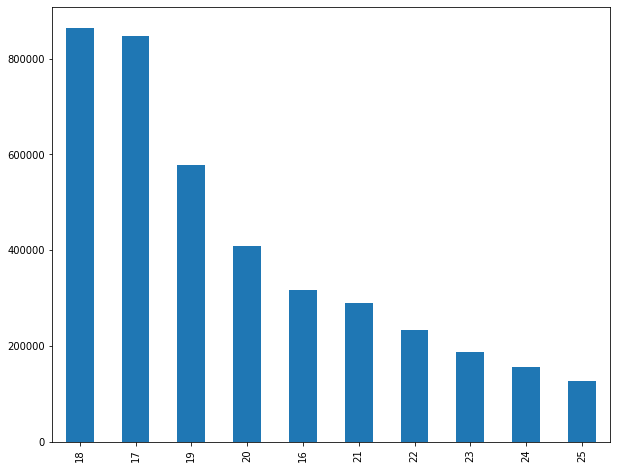

In [124]:
#Top 10  idades com mais participantes que fizeram as provas (treineiros + normais)
df_participantes['IDADE'].value_counts().head(10).plot(kind='bar')


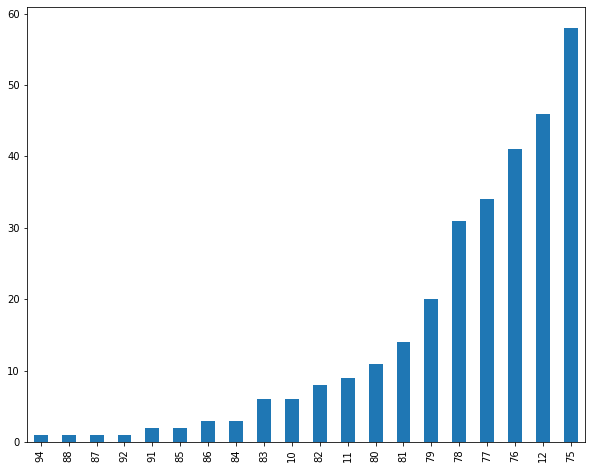

In [125]:
#Top 20 distribuição de idades de com menos participantes (treineios + normais)
df_participantes['IDADE'].value_counts(ascending=True).head(20).plot(kind='bar')


In [82]:
# Quantidade de treineiros 
df_participantes['TREINEIRO'].value_counts()

NÃO    4478602
SIM     616668
Name: TREINEIRO, dtype: int64

Text(0.5, 1.0, 'Participantes treineiros por idade.')

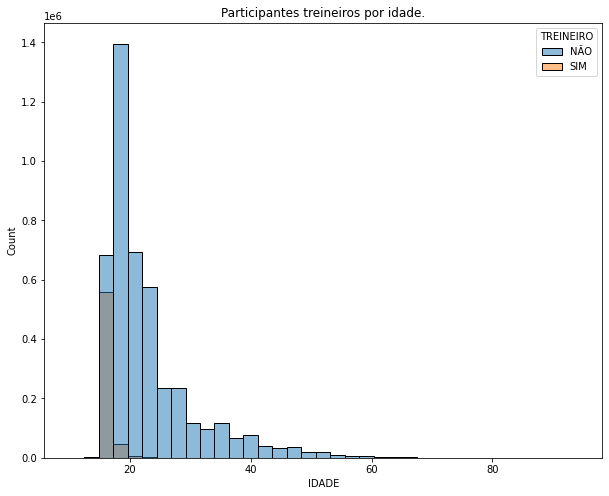

In [141]:
# Distribuição de idades por treineiros
sns.histplot(data=df_participantes, x="IDADE",hue='TREINEIRO', bins=35).set_title("Participantes treineiros por idade.")

Text(0.5, 1.0, 'Distribuição de participantes por idade e sexo')

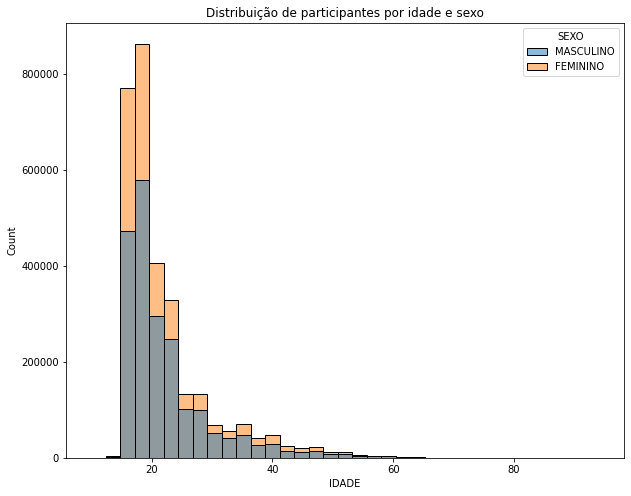

In [140]:
# distribuição de idades por sexo
sns.histplot(data=df_participantes, x="IDADE",hue='SEXO',bins=35).set_title("Distribuição de participantes por idade e sexo")

In [130]:
# distribuição de participantes por sexo
df_participantes['SEXO'].value_counts()

FEMININO     3031822
MASCULINO    2063448
Name: SEXO, dtype: int64

Text(0.5, 1.0, 'Distribuição de Participantes por estado')

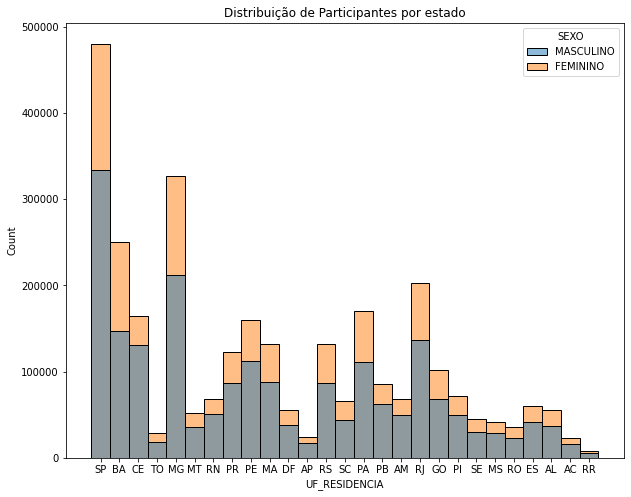

In [139]:
sns.histplot(data=df_participantes, x="UF_RESIDENCIA",hue='SEXO',bins=35).set_title("Distribuição de Participantes por estado")